# Score Threshold Optimization & Visualization

This notebook analyzes optimal score thresholds for transaction categorization. It tests various score cutoffs and visualizes their impact on prediction accuracy, precision, recall, and F1-scores.

## Objectives
- Determine optimal score threshold for category assignment
- Balance precision and recall across different thresholds
- Visualize performance metrics with respect to thresholds
- Generate confusion matrices for threshold evaluation
- Identify threshold with best F1-score or other desired metric

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter


In [2]:
all_df = pd.read_excel("debit_txn_v5.xlsx")

In [3]:
def normalize(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [4]:
all_df["narr_norm"] = all_df["Narration"].apply(normalize)

In [5]:
kw_df = pd.read_excel("keyword_freq_by_category_debit_v5.xlsx")

In [6]:
kw_df['keyword'] = kw_df['keyword'].str.lower().str.strip()

In [7]:
kw_df['score_sq'] = kw_df['score'] ** 2

In [8]:
kw_lookup = (
    kw_df
    .set_index(['keyword', 'category'])['score_sq']
    .to_dict()
)


In [9]:
categories = kw_df['category'].unique()

In [10]:
all_df['tokens'] = (
    all_df['narr_norm']
    .fillna('')
    .str.lower()
    .str.split()
)


In [11]:
for cat in categories:
    all_df[cat] = all_df['tokens'].apply(
        lambda toks: sum(
            kw_lookup.get((t, cat), 0) for t in toks
        )
    )


In [12]:
all_df.drop(columns=['tokens'], inplace=True)


In [13]:
for cat in categories:
    all_df[cat] = np.sqrt(all_df[cat].fillna(0))


In [14]:
all_df['predicted_category'] = (
    all_df[categories]
    .idxmax(axis=1)
    .where(all_df[categories].max(axis=1) > 0)
)


In [15]:
all_df['Category'].unique()

array(['Personal Expense', nan, 'Business Expense - Food Expense',
       'Transfer to Demat',
       'Business Expense - Travelling and Conveyance',
       'Internal Bank Transfers',
       'Business Expense - Printing and Stationary', 'Medical Expenses',
       'Business Expense - Telephone and Internet Charges',
       'Investment in Gold and Silver', 'Business Expense - Bank Charges',
       'Purchase of Mutual Fund', 'TDS Paid', 'Cash Withdrawal',
       'Rent Payments', 'Business Expense - Electricity Expense',
       'Income Tax Paid', 'EMIs paid', 'Investment in Recurring Deposit',
       'Investment in Fixed Deposit', 'Credit Card Payment',
       'Business Expense - Labour Charges',
       'Business Expense - Promotion',
       'Business Expense - Advertisement and Marketing',
       'Business Expense - Salary Paid',
       'Business Expense - Transportation Charges', 'Investment in PPF',
       'Business Expense - Bank/Loan Interest', 'Municipal Tax Paid',
       'Investment

In [16]:
count = (
    all_df['Category']
    .str.strip().str.lower()
    .isin([c.strip().lower() for c in categories])
    .sum()
)

print(count)

N_VALID=count

113484


In [17]:
def accuracy_for_score(score_threshold):
    # --- filter keywords based on SCORE only ---
    # keep keyword if it crosses threshold in at least one category
    valid_keywords = (
        kw_df[kw_df["score"] > score_threshold]
        .groupby("keyword")
        .size()
        .index
    )

    kw_filt = kw_df[kw_df["keyword"].isin(valid_keywords)]
    if kw_filt.empty:
        return np.nan

    # --- build (category → keyword → score²) ---
    kw_map = {}
    for cat, g in kw_filt.groupby("category"):
        kw_map[cat.strip().lower()] = dict(
            zip(
                g["keyword"].str.lower(),
                g["score"] ** 2
            )
        )

    categories = list(kw_map.keys())

    # --- compute scores for each narration ---
    scores = []
    for narr in all_df["narr_norm"].fillna("").str.lower():
        tokens = set(narr.split())
        row_scores = {}
        for cat in categories:
            s = 0
            for kw, sc in kw_map[cat].items():
                if kw in tokens:
                    s += sc
            row_scores[cat] = s
        scores.append(row_scores)

    score_df = pd.DataFrame(scores).fillna(0)

    # --- predicted category ---
    preds = score_df.idxmax(axis=1).str.lower()

    # --- accuracy (case-insensitive) ---
    correct = (preds == all_df['Category'].str.strip().str.lower()).sum()
    accuracy = (correct * 100) / N_VALID

    return accuracy


In [18]:
score_thresholds = range(0, 101, 5)

acc_results = []
for t in score_thresholds:
    acc_results.append({
        "score_threshold": t,
        "accuracy": accuracy_for_score(t)
    })

score_acc_df = pd.DataFrame(acc_results)


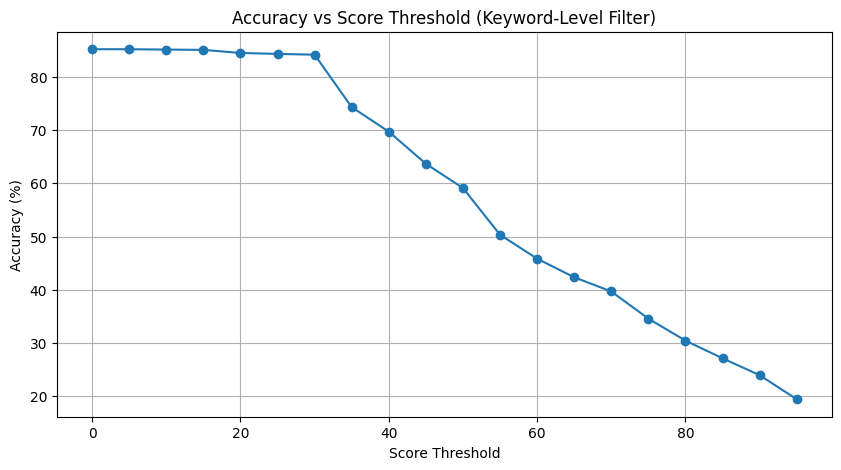

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(
    score_acc_df["score_threshold"],
    score_acc_df["accuracy"],
    marker="o"
)
plt.xlabel("Score Threshold")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Score Threshold (Keyword-Level Filter)")
plt.grid(True)
plt.show()
